In [1]:
%load_ext autoreload
%autoreload 2

class StopExecution(Exception):
    def _render_traceback_(self):
        return []



In [2]:
import sys
sys.path.append("..")
import pickle as pkl
import hist
from analyzer.core import AnalysisResult
from analyzer.datasets import SampleManager
import math
import torch
import gpytorch
from analyzer.plotting.core_plots import *
loadStyles()
import matplotlib
from torch.masked import masked_tensor, as_masked_tensor
matplotlib.rcParams['figure.figsize'] = (3, 3)

In [3]:
res = AnalysisResult.fromFile("../results/newanalyzer.pkl")

In [4]:
sample_manager = SampleManager()
sample_manager.loadSamplesFromDirectory("../datasets")

In [5]:
hists = res.getMergedHistograms(sample_manager)

In [220]:
m14_vs_m24 = hists["ratio_m14_vs_m24"]
narrowed = m14_vs_m24
#orig =  m14_vs_m24[...,hist.loc(1100):hist.loc(2500),hist.loc(400):hist.loc(2000)]
orig =  m14_vs_m24[...,hist.loc(1100):hist.loc(2500),hist.loc(0.4):hist.loc(1)]

narrowed = orig
narrowed = orig[...,::hist.rebin(2),::hist.rebin(2)]



qcd_m14_vs_m24 = narrowed["Skim_QCDInclusive2018",...]
orig_qcd_m14_vs_m24 = orig["Skim_QCDInclusive2018",...]

sig_m14_vs_m24 = narrowed["signal_312_2000_1400",...]

qcd_m14_vs_m24 = narrowed["Skim_QCDInclusive2018",...] + 20 * sig_m14_vs_m24


In [221]:
def addColorbar(ax, vals):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(vals, cax=cax)
    cax.get_yaxis().set_offset_position("left")
    ax.cax = cax

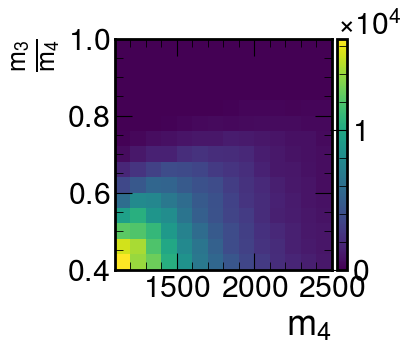

In [222]:
_ = drawAs2DHist(PlotObject(qcd_m14_vs_m24))

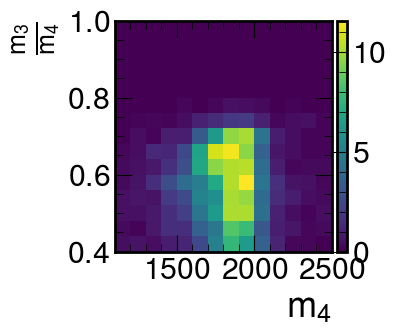

In [223]:
_ = drawAs2DHist(PlotObject(sig_m14_vs_m24))

In [224]:
def make_mask(x1,x2):
    a = (x1 > 2100 ) | (x1 < 1700) 
    b = (x2 > 0.76 ) | ( x2 < 0.5)
    return a,b

edges_x1 = torch.from_numpy(qcd_m14_vs_m24.axes[0].edges)
edges_x2 = torch.from_numpy(qcd_m14_vs_m24.axes[1].edges)
centers_x1 = torch.diff(edges_x1) /2  + edges_x1[:-1] 
centers_x2 = torch.diff(edges_x2) /2  + edges_x2[:-1] 

bin_values = torch.from_numpy(qcd_m14_vs_m24.values()).T
bin_vars = torch.from_numpy(qcd_m14_vs_m24.variances()).T

emask_x1,emask_x2 = make_mask(edges_x1, edges_x2)
centers_grid_x1,centers_grid_x2 = torch.meshgrid(centers_x1,centers_x2,indexing='xy')

cmask_x1,cmask_x2 = make_mask(centers_x1, centers_x2)


centers_grid = torch.stack((centers_grid_x1,centers_grid_x2), axis=2)
m1,m2 = make_mask(centers_grid[:,:,0] , centers_grid[:,:,1])
centers_mask = m1 | m2
flat_centers = torch.flatten(centers_grid, end_dim=1)
flat_bin_values = torch.flatten(bin_values)
flat_bin_vars = torch.flatten(bin_vars)
ma = torch.max(flat_centers.T,axis=1).values
mi = torch.min(flat_centers.T,axis=1).values
transformed_centers = (flat_centers - mi) / (ma-mi)
ma = torch.max(flat_centers)
mi = torch.min(flat_centers)
transformed_values = (flat_bin_values - mi) / (ma-mi)
transformed_vars = (flat_bin_vars) / (ma-mi)



flat_centers_masked = transformed_centers[torch.flatten(centers_mask)]
flat_bin_values_masked = transformed_values[torch.flatten(centers_mask)]
flat_bin_vars_masked = transformed_vars[torch.flatten(centers_mask)]

train_x = flat_centers_masked
train_y = flat_bin_values_masked
train_vars = flat_bin_vars_masked
test_x = transformed_centers
test_y = transformed_values
test_vars = transformed_vars

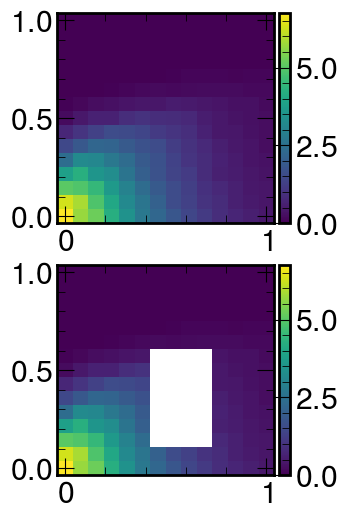

In [225]:
fig,ax = plt.subplots(2,1, figsize=(3,6))
def simpleGrid(ax, inx,iny):
    x=np.unique(inx[:,0])
    y=np.unique(inx[:,1])
    X,Y = np.meshgrid(x,y)
    z=iny
    Z=z.reshape(len(y),len(x))
    f = ax.pcolormesh(X,Y,Z)
    addColorbar(ax,f)
    return f
    
simpleGrid(ax[0],test_x,test_y)
simpleGrid(ax[1],test_x, np.ma.masked_where(~torch.flatten(centers_mask), test_y))

In [226]:
# We will use the simplest form of GP model, exact inference
class ExactProjGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(ard_num_dims=2)
        )
        #self.proj_mat = torch.nn.Parameter(torch.tensor([[1,1],[1,0]], dtype=torch.float64)) 
        self.rot = torch.nn.Parameter(torch.tensor(0.78,dtype=torch.float64))
    def forward(self, x):
        rot_mat = torch.tensor([
            [torch.cos(self.rot), -torch.sin(self.rot)],
            [torch.sin(self.rot), torch.cos(self.rot)]
        ])
        x = x @ rot_mat   # n x d * d x k --> n x k
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(ard_num_dims=2)
        )
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
    
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
class ExactPeakedGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(ard_num_dims=2)
        )
        
        self.covar_peak_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(ard_num_dims=2)
        )
        self.peak = torch.nn.Parameter(torch.tensor([0.8,0.2], dtype=torch.float64)) 
        
    def forward(self, x):
        subbed = x-self.peak
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x) * self.covar_peak_module(subbed)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


class _ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMeanGrad()
        self.base_kernel = gpytorch.kernels.RBFKernelGrad(ard_num_dims=2)
        self.covar_module = gpytorch.kernels.ScaleKernel(self.base_kernel)
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)


In [233]:
#likelihood = gpytorch.likelihoods.FixedNoiseGaussianLikelihood(noise=train_vars, learn_additional_noise=False)
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)
#model = ExactProjGPModel(train_x, train_y, likelihood)
#model = ExactPeakedGPModel(train_x, train_y, likelihood)
# model.covar_module.base_kernel.lengthscale = torch.tensor([200,200])
# model.covar_module.base_kernel.raw_outputscale = 1e7
for param_name, param in model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param}')
model.train()
likelihood.train()
print(list(model.likelihood.parameters()))
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

# optimizer = torch.optim.Adam([
#         {'params': model.covar_module.base_kernel.raw_lengthscale, 'lr': 20},
#         {'params': model.covar_module.raw_outputscale, 'lr': 5e6},
#         #{'params': model.proj_mat, 'lr': 0.25},   
#         {'params': model.mean_module.parameters(), 'lr': 1e4},
#        # {"params" : model.likelihood.parameters(), 'lr' : 1e2}
# ])


mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
iterations = 100
for i in range(iterations):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    if not (i+1)% (iterations / 10 ) or i == 0:
        print('Iter {:d} - Loss: {:0.3f}   lengthscale: {:0.4f},{:0.4f}  scale: {:0.3f}  mean:{:0.3f} noise:{:0.3f} '.format(
        i + 1,  loss.item(),
        model.covar_module.base_kernel.lengthscale.squeeze()[0],
        model.covar_module.base_kernel.lengthscale.squeeze()[1],
        model.covar_module.outputscale.item(),
        model.mean_module.constant.item(), 
        likelihood.noise.mean()
    )
         )
        #print(model.proj_mat)
    optimizer.step()

# this is for running the notebook in our testing framework
for param_name, param in model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param}')


#model.covar_module.base_kernel.lengthscale = [0.3,0.3]
#model.proj_mat = torch.nn.Parameter(torch.tensor([[-1,1],[1,-1]], dtype=torch.float64)) 

Parameter name: likelihood.noise_covar.raw_noise           value = Parameter containing:
tensor([0.], requires_grad=True)
Parameter name: mean_module.raw_constant                   value = Parameter containing:
tensor(0., requires_grad=True)
Parameter name: covar_module.raw_outputscale               value = Parameter containing:
tensor(0., requires_grad=True)
Parameter name: covar_module.base_kernel.raw_lengthscale   value = Parameter containing:
tensor([[0., 0.]], requires_grad=True)
[Parameter containing:
tensor([0.], requires_grad=True)]
Iter 1 - Loss: 1.076   lengthscale: 0.6931,0.6931  scale: 0.693  mean:0.000 noise:0.693 
Iter 10 - Loss: 0.823   lengthscale: 0.4953,0.4941  scale: 0.939  mean:0.443 noise:0.492 
Iter 20 - Loss: 0.591   lengthscale: 0.3624,0.3458  scale: 1.220  mean:0.877 noise:0.321 
Iter 30 - Loss: 0.389   lengthscale: 0.3488,0.2813  scale: 1.438  mean:1.166 noise:0.201 
Iter 40 - Loss: 0.183   lengthscale: 0.4056,0.2772  scale: 1.591  mean:1.281 noise:0.122 
Iter

In [228]:
#likelihood = gpytorch.likelihoods.FixedNoiseGaussianLikelihood(noise=test_vars, learn_additional_noise=False)

#likelihood = gpytorch.likelihoods.GaussianLikelihood()
#likelihood = gpytorch.likelihoods.FixedNoiseGaussianLikelihood(noise=0.1*torch.ones_like(train_y), learn_additional_noise=False)
#model = ExactGPModel(train_x, train_y, likelihood)

#model.covar_module.base_kernel.lengthscale = [2,0.25]



# this is for running the notebook in our testing framework
for param_name, param in model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param}')
model.eval()
likelihood.eval()

Parameter name: likelihood.noise_covar.raw_noise           value = Parameter containing:
tensor([-4.9087], requires_grad=True)
Parameter name: mean_module.raw_constant                   value = Parameter containing:
tensor(1.0413, requires_grad=True)
Parameter name: covar_module.raw_outputscale               value = Parameter containing:
tensor(2.1386, requires_grad=True)
Parameter name: covar_module.base_kernel.raw_lengthscale   value = Parameter containing:
tensor([[-0.8774, -1.2927]], requires_grad=True)


GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

In [229]:

with torch.no_grad(), gpytorch.settings.fast_computations():
    #test_x = train_x.flatten()
    observed_pred = likelihood(model(test_x))
    trained_pred_dist = likelihood(model(test_x))
    #observed_pred = model(test_x)

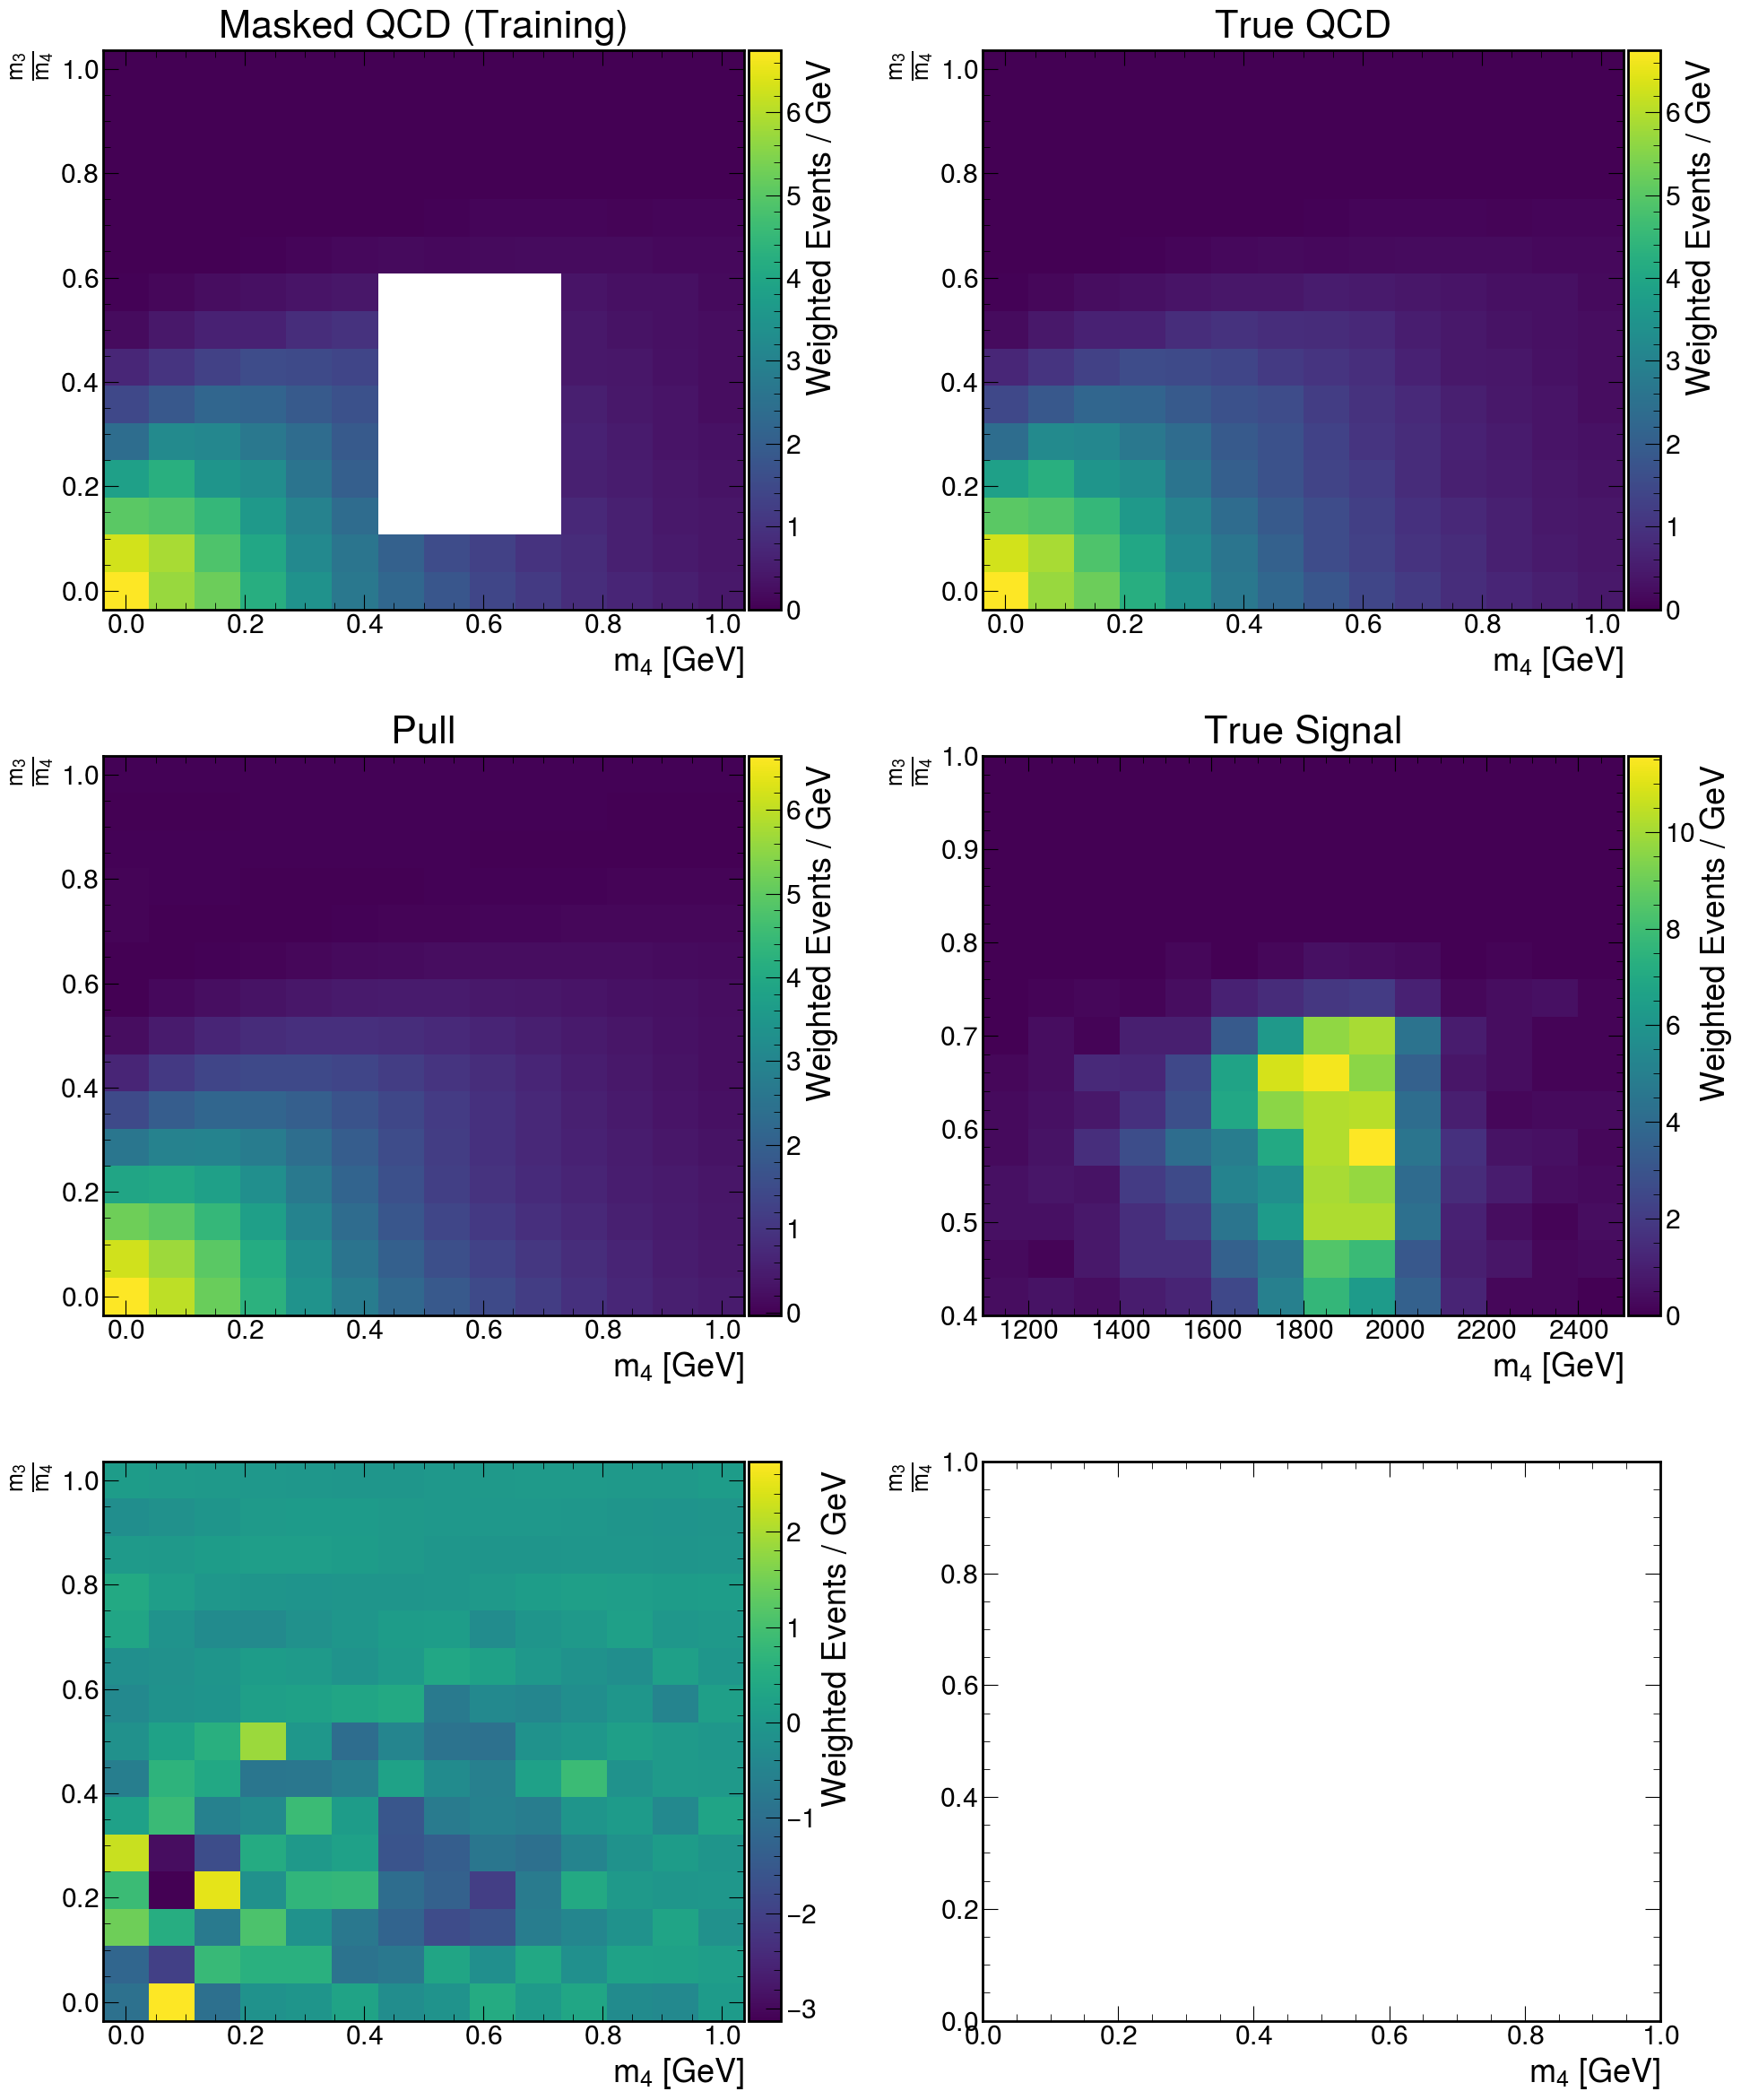

In [230]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import itertools as it
r = torch.reshape(observed_pred.mean, test_y.shape)
pred_var = torch.reshape(observed_pred.variance, test_y.shape)

#r = (r  * train_y_std) + train_y_mean
final_nlpd = gpytorch.metrics.negative_log_predictive_density(trained_pred_dist, test_y)
x2 = torch.sum((observed_pred.mean - test_y)**2 / observed_pred.variance)
def addColorbar(ax, vals):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(vals, cax=cax)
    cax.get_yaxis().set_offset_position("left")
    ax.cax = cax


fig, ax=plt.subplots(3,2, figsize=(20,24), layout="tight")

f = simpleGrid(ax[0,0], test_x, np.ma.masked_where(~centers_mask,torch.reshape(test_y, centers_mask.shape)))
#ax[0,0].pcolormesh(*torch.unbind(centers_grid,axis=2), np.ma.masked_where(~centers_mask,bin_values))
ax[0,0].set_title("Masked QCD (Training)")

f = simpleGrid(ax[1,0], test_x, r)
#f = ax[1,0].pcolormesh(*torch.unbind(centers_grid,axis=2), r)
ax[1,0].set_title("GP Prediction")



f = simpleGrid(ax[0,1], test_x, test_y)
#f=ax[0,1].pcolormesh(*torch.unbind(centers_grid,axis=2), bin_values)
ax[0,1].set_title("True QCD")


drawAs2DHist(ax[1,1], PlotObject(sig_m14_vs_m24))
addTitles2D(ax[1,1], sig_m14_vs_m24)
ax[1,1].set_title("True Signal")


f = simpleGrid(ax[2,0], test_x, (r-test_y) / torch.sqrt(pred_var))
#f = ax[1,0].pcolormesh(*torch.unbind(centers_grid,axis=2), r)
ax[1,0].set_title("Pull")


for  x in it.chain(*ax):
    addTitles2D(x, sig_m14_vs_m24)

fig.savefig("../figures/current_gp_work.pdf")




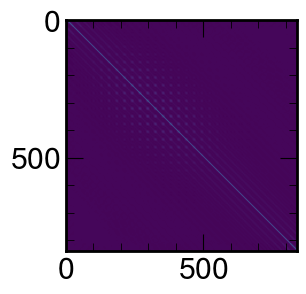

In [218]:
im = observed_pred.covariance_matrix
fig,ax = plt.subplots()
ax.imshow(im)